# Customer Segmentation

**Customer Segmentation** is the process by which we divide our customers up based on **common characteristics** (demographics, behaviour, etc). The objective of customer segmentation is to **market** those customers more **effectively**. The customer segments could be used to create a **persona**, a personification of a customer segment, that could be used to **understand** the customer's needs **better**.

**The rule of customer segmentation by their behaviour**

1. **Recency**: How recently did the customer purchase?
2. **Frequency**: How often do they purchase?
3. **Monetary**: How much do they spend?

A customer who have **purchased recently**, **purchased more often**, and **spend more** is more likely to purchase our product again.

**Why is it important?**

Not just important, but **vital**, in order to optimize our marketing strategies, maximize a customer's value, and improve customer experience. Also, to make sure our communication are both **effective** and **appropriate**.

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [1]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [2]:
# Load data
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [4]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [5]:
# Remove missing value
#notna() - only use data not null
df = df[df["CustomerID"].notna()]

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Then we could do some descriptive statistic.

In [6]:
# Simple descriptive statistic
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [7]:
# Check anomaly data
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


Then just remove those anomaly data

In [8]:
# Remove anomaly
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Now we're good to go. Lets do some data exploration!

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


The data contains 397884 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

## Feature Engineering

In [10]:
# Check unique value
df[['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']].nunique()

InvoiceNo      18532
StockCode       3665
Description     3877
CustomerID      4338
Country           37
dtype: int64

There are 18532 purchasements, 3665 unique item purchased on 3877 types of product, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

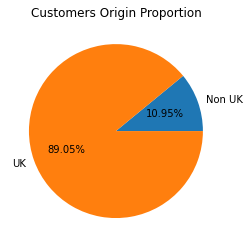

In [11]:
# Simplify country origin
df['Country_isUK'] = np.where(df['Country'] == 'United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

_ = plt.title('Customers Origin Proportion')
_ = plt.pie(customers_origin, labels = customers_origin.index, autopct = lambda p: f'{p:.2f}%')
plt.show()

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [12]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


In [13]:
# Create new features by splitting InvoiceDate column into year, month, date and time column separately
df['Day'] = (df['InvoiceDate']).dt.day
df['DayName'] = (df['InvoiceDate']).dt.day_name()
df['Month'] = (df['InvoiceDate']).dt.month
df['Year'] = (df['InvoiceDate']).dt.year
df['Time'] = (df['InvoiceDate']).dt.strftime('%H:%M')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount,Day,DayName,Month,Year,Time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30,1,Wednesday,12,2010,08:26
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34,1,Wednesday,12,2010,08:26
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00,1,Wednesday,12,2010,08:26
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34,1,Wednesday,12,2010,08:26
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34,1,Wednesday,12,2010,08:26


**Find 5 customers with the most purchases**

In [14]:
customer = df.groupby('CustomerID').agg({'TotalAmount':'max'}).\
        sort_values(by=['TotalAmount'], ascending=False).reset_index()
customer['CustomerID'] = customer['CustomerID'].astype(str)
customer.head()

,CustomerID,TotalAmount
0,16446.0,168469.60
1,12346.0,77183.60
2,15098.0,38970.00
3,16029.0,8142.75
4,17450.0,7144.72


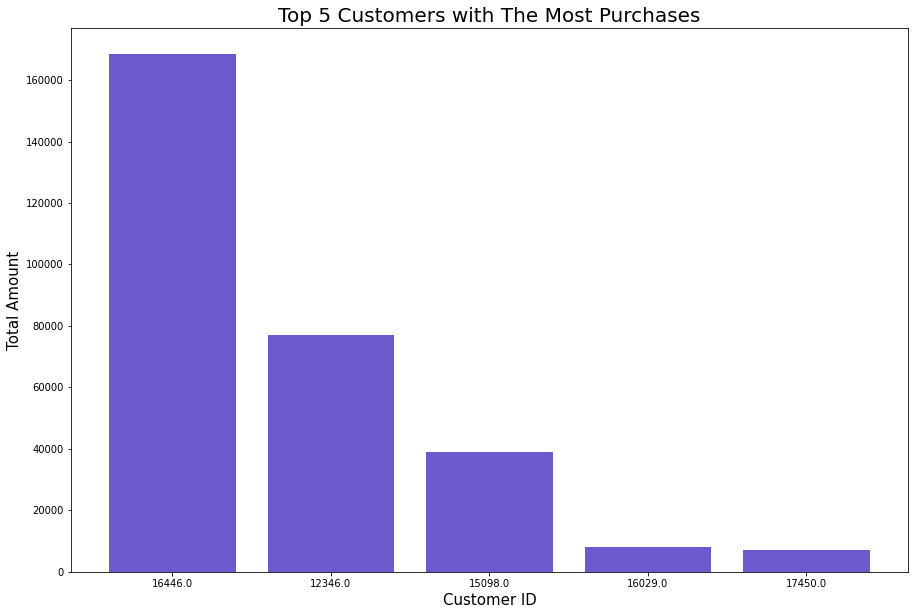

In [15]:
fig = plt.figure(figsize = (15,10))
plt.bar(customer['CustomerID'][:5], customer['TotalAmount'][:5], color = 'slateblue')
plt.title('Top 5 Customers with The Most Purchases', fontsize = 20)
plt.ylabel('Total Amount', fontsize = 15)
plt.xlabel('Customer ID', fontsize = 15)
plt.show()

**When is the time to purchase with the largest number of customers?**

In [16]:
purchase = df.groupby('InvoiceDate').agg({'CustomerID':'count'}).\
        sort_values(by=['CustomerID'], ascending=False).reset_index()

purchase['DayName'] = (purchase['InvoiceDate']).dt.day_name()
purchase['Week'] = (purchase['InvoiceDate']).dt.isocalendar().week
purchase['Day'] = (purchase['InvoiceDate']).dt.day
purchase['Month'] = (purchase['InvoiceDate']).dt.month_name()
purchase['Year'] = (purchase['InvoiceDate']).dt.year
purchase['Time'] = (purchase['InvoiceDate']).dt.strftime('%H:%M')

purchase.head()

,InvoiceDate,CustomerID,DayName,Week,Day,Month,Year,Time
0,2011-11-14 15:27:00,542,Monday,46,14,November,2011,15:27
1,2011-11-28 15:54:00,533,Monday,48,28,November,2011,15:54
2,2011-12-05 17:17:00,529,Monday,49,5,December,2011,17:17
3,2011-11-23 13:39:00,443,Wednesday,47,23,November,2011,13:39
4,2011-10-31 14:09:00,435,Monday,44,31,October,2011,14:09


**Which item is the most popular?**

In [17]:
item = df.groupby(['Description']).agg({'Description': 'count',
                                        'Quantity': 'sum'})
item.rename(columns = {'Description': 'Count'}, inplace = True)
item = item.sort_values('Quantity', ascending = False)
item.head()

,Count,Quantity
Description,,
"PAPER CRAFT , LITTLE BIRDIE",1,80995
MEDIUM CERAMIC TOP STORAGE JAR,198,77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS,473,54415
JUMBO BAG RED RETROSPOT,1618,46181
WHITE HANGING HEART T-LIGHT HOLDER,2028,36725


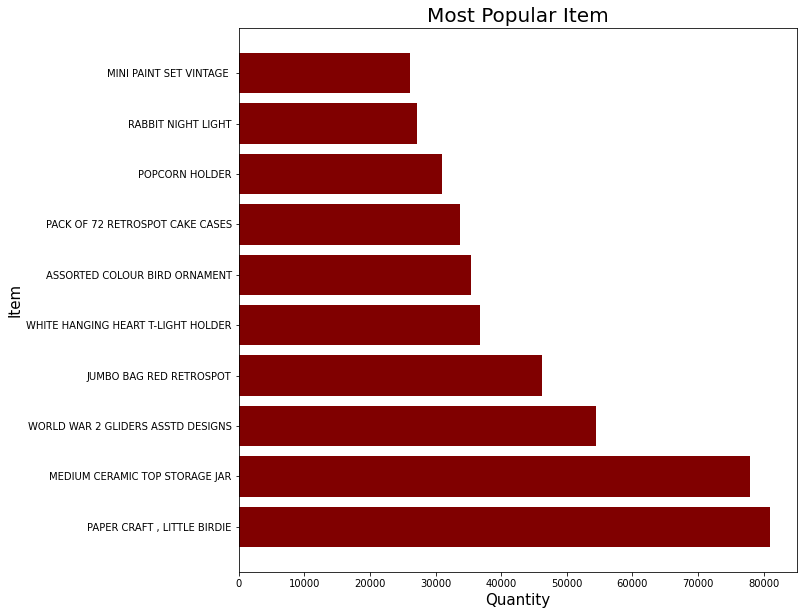

In [18]:
fig = plt.figure(figsize = (10,10))
plt.barh(item[:10].index, item['Quantity'][:10], color = 'maroon')
plt.title('Most Popular Item', fontsize = 20)
plt.ylabel('Item', fontsize = 15)
plt.xlabel('Quantity', fontsize = 15)
plt.show()

**How many sale in each country?**

In [19]:
sale = df.groupby(['Country']).agg({'TotalAmount': 'sum'}).\
      sort_values(by = ['TotalAmount'], ascending = False).reset_index()
sale.head()

,Country,TotalAmount
0,United Kingdom,7308391.554
1,Netherlands,285446.340
2,EIRE,265545.900
3,Germany,228867.140
4,France,209024.050


**Which month has highest sale?**

In [20]:
month = df.groupby(['Month']).agg({'TotalAmount': 'sum'}).reset_index()
month.head()

,Month,TotalAmount
0,1,569445.040
1,2,447137.350
2,3,595500.760
3,4,469200.361
4,5,678594.560


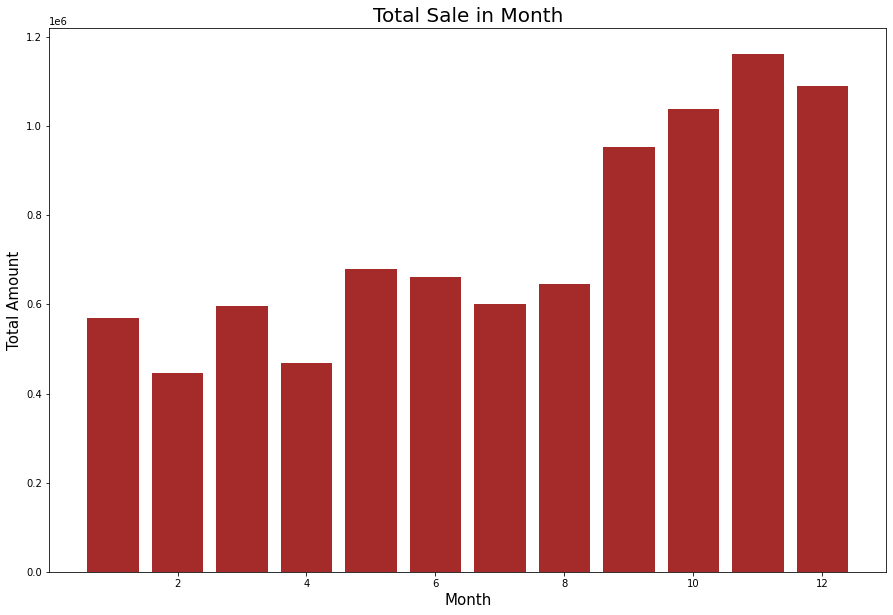

In [21]:
fig = plt.figure(figsize = (15,10))
plt.bar(month['Month'], month['TotalAmount'], color = 'brown')
plt.title('Total Sale in Month', fontsize = 20)
plt.ylabel('Total Amount', fontsize = 15)
plt.xlabel('Month', fontsize = 15)
plt.show()

**When the popular day of sale?**

In [22]:
df['Year'].unique()

array([2010, 2011])

In [23]:
day = df.groupby(['DayName',]).agg({'TotalAmount': 'sum'}).reset_index()
day

,DayName,TotalAmount
0,Friday,1485917.401
1,Monday,1367146.411
2,Sunday,792514.221
3,Thursday,1976859.070
4,Tuesday,1700634.631
5,Wednesday,1588336.170


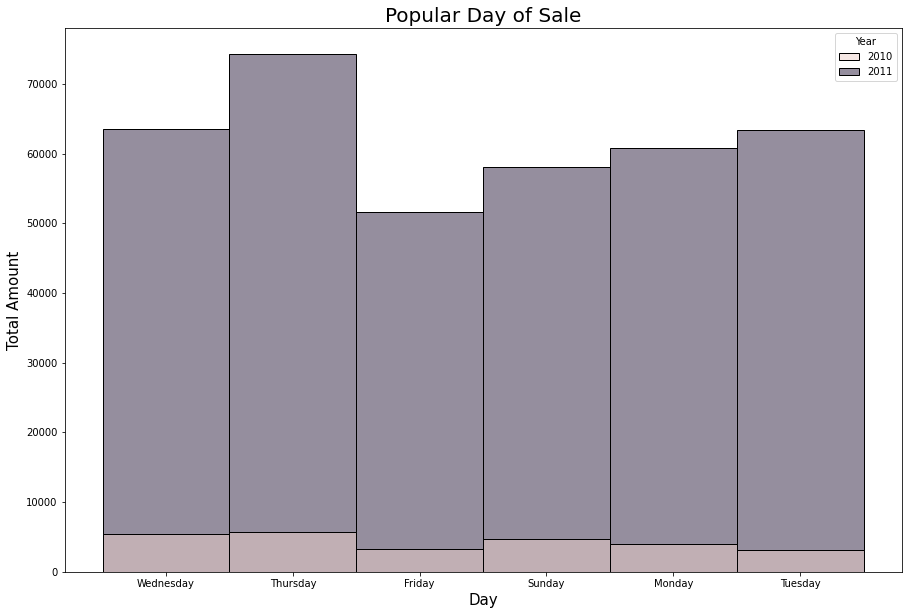

In [24]:
fig = plt.figure(figsize = (15,10))
sns.histplot(data = df, x = df['DayName'], hue = 'Year', binwidth = 1)
plt.title('Popular Day of Sale', fontsize = 20)
plt.ylabel('Total Amount', fontsize = 15)
plt.xlabel('Day', fontsize = 15)
plt.show()

Then plot the trendline.

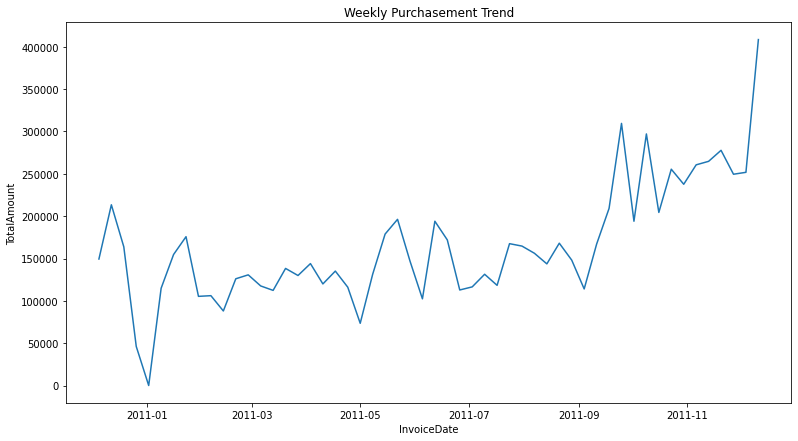

In [25]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

_ = plt.figure(figsize=(13, 7))  
_ = plt.title('Weekly Purchasement Trend')
_ = sns.lineplot(x = weekly_purchasements.index, y = weekly_purchasements)
plt.show()

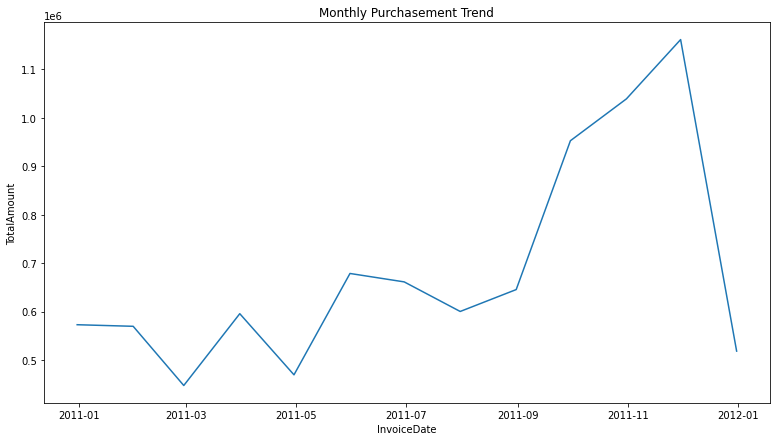

In [26]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

_ = plt.figure(figsize=(13, 7))  
_ = plt.title('Monthly Purchasement Trend')
_ = sns.lineplot(x = monthly_purchasements.index, y = monthly_purchasements)
plt.show()

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [27]:
# Get customer's recency
recency = df.groupby(['CustomerID'])['InvoiceDate'].max()
recency = max(recency) - recency
recency = recency.dt.days
recency = recency.rename('Recency')

recency.head()

CustomerID
12346.0    325
12347.0      1
12348.0     74
12349.0     18
12350.0    309
Name: Recency, dtype: int64

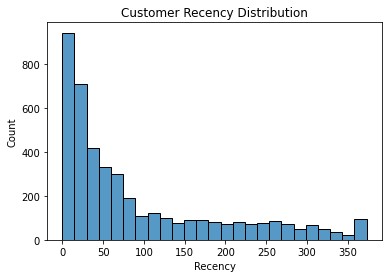

In [28]:
# Recency histogram plot
_ = plt.title('Customer Recency Distribution')
_ = sns.histplot(recency)
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [29]:
# Count frequency
frequency = df.groupby(['CustomerID'])['InvoiceNo'].count()
frequency = frequency.rename('Frequency')

frequency.head()

CustomerID
12346.0      1
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: Frequency, dtype: int64

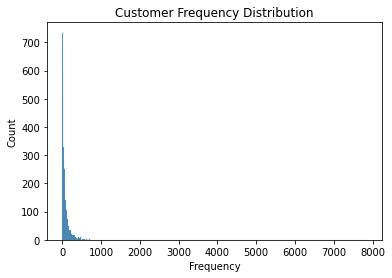

In [30]:
# Frequency histogram plot
_ = plt.title('Customer Frequency Distribution')
_ = sns.histplot(frequency)
plt.show()

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [31]:
# Sum the money spent
monetary = df.groupby(['CustomerID'])['TotalAmount'].sum()
monetary = monetary.rename('Monetary')

monetary.head()

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
Name: Monetary, dtype: float64

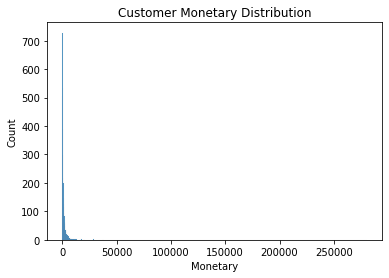

In [32]:
# Monetary histogram plot
_ = plt.title('Customer Monetary Distribution')
_ = sns.histplot(monetary)
plt.show()

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [33]:
# Get customer's country of origin
country = df.groupby(['CustomerID', 'Country_isUK']).size().reset_index().drop(0, axis = 1)

# Merge the data
df_new = country \
    .merge(recency, on = 'CustomerID') \
    .merge(frequency, on = 'CustomerID') \
    .merge(monetary, on = 'CustomerID')

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')

df_new.head()

,Country_isUK,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [34]:
# Recode the non numeric variable

df_new = pd.get_dummies(df_new, columns=['Country_isUK'], drop_first=True)
df_new = df_new.rename(columns = {'Country_isUK_UK': 'Country_UK'})

df_new.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,182,4310.00,0
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,309,17,334.40,0


### Scaling

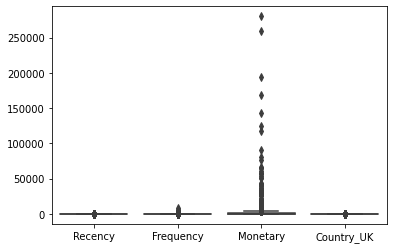

In [35]:
_ = sns.boxplot(data = df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [36]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(df_scaled, columns = df_new.columns, index = df_new.index)

df_scaled.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


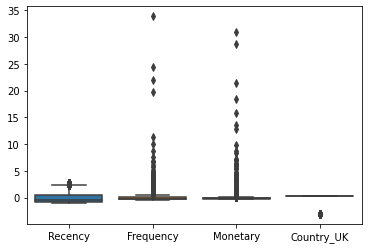

In [37]:
# Plot scaled data
_ = sns.boxplot(data = df_scaled)
plt.show()

## Modeling

In [38]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters = k, random_state = 123).fit(df_scaled)
    
    silhouette.append(silhouette_score(X = df_scaled, labels = kmeans.labels_))

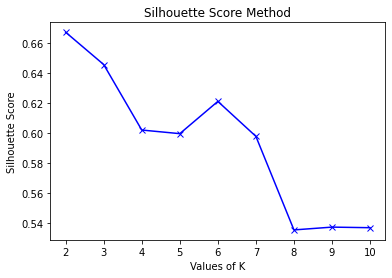

In [39]:
# Plot the score
plt.plot(possible_k, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

Using silhouette score, the best K is either 2 or 6

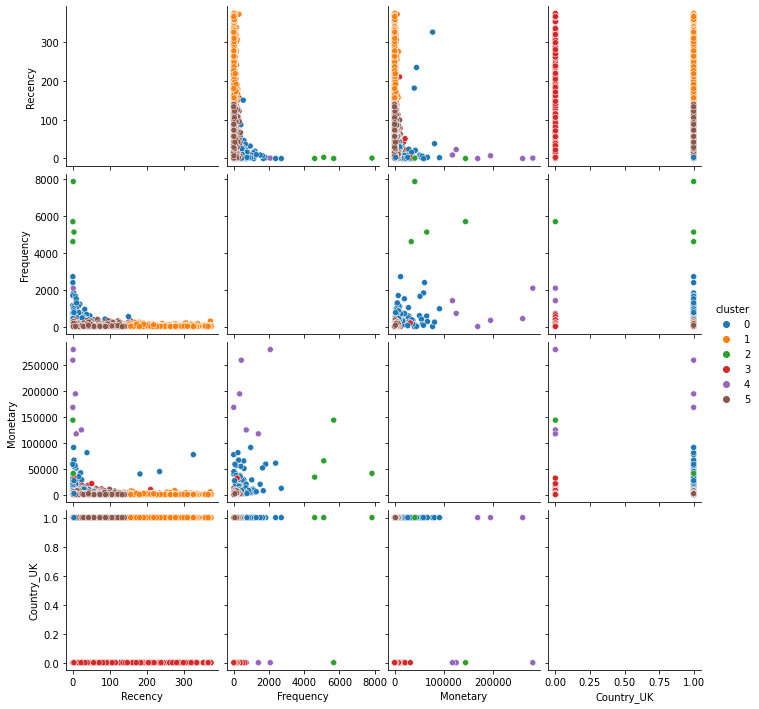

In [40]:
kmeans = KMeans(n_clusters = 6, random_state = 123).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

_ = sns.pairplot(data = df_result_kmeans, hue = 'cluster', diag_kind = 'None', palette = 'tab10')
plt.show()

In [41]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
df_result_kmeans \
    .drop("Country_UK", axis = 1) \
    .groupby('cluster') \
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max']) \
    .transpose()

cluster                      0            1              2             3  \
Recency   mean       15.234973   246.776618       1.000000     95.405797   
          std        35.305176    65.636727       1.414214    104.638705   
          min         0.000000   143.000000       0.000000      0.000000   
          q25         2.000000   189.000000       0.000000     18.000000   
          median      6.000000   242.000000       0.500000     52.000000   
          q75        16.000000   296.000000       1.500000    136.500000   
          max       325.000000   373.000000       3.000000    373.000000   
Frequency mean      535.360656    27.689979    5807.000000     81.396135   
          std       358.078267    32.176026    1429.730044     96.304061   
          min         1.000000     1.000000    4595.000000      1.000000   
          q25       367.000000     8.250000    4982.000000     21.250000   
          median    450.000000    18.000000    5393.000000     45.000000   
          q75       589.500000    33.000000    6218.000000    101.000000   
          max      2700.000000   297.000000    7847.000000    638.000000   
Monetary  mean    13085.065738   450.793070   70925.287500   2262.538913   
          std     16313.461152   610.367153   50424.336433   3479.689136   
          min      1093.650000     3.750000   33719.730000     51.560000   
          q25      4014.945000   163.225000   39173.610000    459.650000   
          median   6923.130000   305.515000   53078.180000   1025.700000   
          q75     13213.210000   505.542500   84829.857500   2659.962500   
          max     91062.380000  7832.470000  143825.060000  31906.820000   

cluster                       4             5  
Recency   mean         6.666667     42.676884  
          std          8.869423     36.313016  
          min          0.000000      0.000000  
          q25          0.250000     14.000000  
          median       4.000000     31.000000  
          q75          8.500000     64.000000  
          max         23.000000    155.000000  
Frequency mean       826.833333     76.270826  
          std        771.620481     74.030983  
          min          3.000000      1.000000  
          q25        360.500000     22.000000  
          median     572.500000     51.000000  
          q75       1228.500000    107.000000  
          max       2076.000000    385.000000  
Monetary  mean    190863.461667   1341.293935  
          std      67791.993010   1592.871914  
          min     117379.630000      6.200000  
          q25     135804.022500    371.700000  
          median  181511.645000    795.120000  
          q75     243380.672500   1720.300000  
          max     280206.020000  17654.540000

**Characteristics of each cluster**

Cluster 0
- country: UK, Recency: 0-325 days, Frequency: < 3000, Monetary: < 100000

Cluster 1
- country: UK, Recency: 143-373 days, Frequency: < 300, Monetary: < 8000

Cluster 2
- country: UK & Non-UK, Recency: > 7 days, Frequency: 4000 - 8000, Monetary: 30000 - 150000

Cluster 3
- country: Non-UK, Recency: 0-373 days, Frequency: < 650, Monetary: 50 - 350000

Cluster 4
- country: UK & Non-UK, Recency: < 30 days, Frequency: 3 - 2100, Monetary: 115000 - 300000

Cluster 5
- country: UK, Recency: < 160 days, Frequency: < 400, Monetary: 5 - 20000

In [42]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

cluster  Country_UK
0        1              183
1        1              958
2        0                1
         1                3
3        0              414
4        0                3
         1                3
5        1             2773
Name: Recency, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we do clustering only for the customer non-UK?

# Customer Segmentation (Non-UK Customers)

## Prepare the data

We have to filter the main dataset so that the dataset contains only non-UK costumers.

In [43]:
# Get customer's country of origin
data = df.copy()
data = data[data['Country'] != 'United Kingdom']

non_uk = data.groupby(['CustomerID', 'Country']).size().reset_index().drop(0, axis = 1)

# Merge the data
data_new = non_uk \
    .merge(recency, on = 'CustomerID') \
    .merge(frequency, on = 'CustomerID') \
    .merge(monetary, on = 'CustomerID')

# Set CustomerID as index
data_new = data_new.set_index('CustomerID')

data_new.head()

,Country,Recency,Frequency,Monetary
CustomerID,,,,
12347.0,Iceland,1,182,4310.00
12348.0,Finland,74,31,1797.24
12349.0,Italy,18,73,1757.55
12350.0,Norway,309,17,334.40
12352.0,Norway,35,85,2506.04


In [ ]:
data_new['Country'].unique()

array(['Iceland', 'Finland', 'Italy', 'Norway', 'Bahrain', 'Spain',
       'Portugal', 'Switzerland', 'Austria', 'Cyprus', 'Belgium',
       'Unspecified', 'Denmark', 'Australia', 'France', 'Germany', 'RSA',
       'Greece', 'Sweden', 'Israel', 'USA', 'Saudi Arabia', 'Poland',
       'United Arab Emirates', 'Singapore', 'Japan', 'Netherlands',
       'Lebanon', 'Brazil', 'Czech Republic', 'EIRE', 'Channel Islands',
       'European Community', 'Lithuania', 'Canada', 'Malta'], dtype=object)

Do some visualization about RFM of non-UK customers.

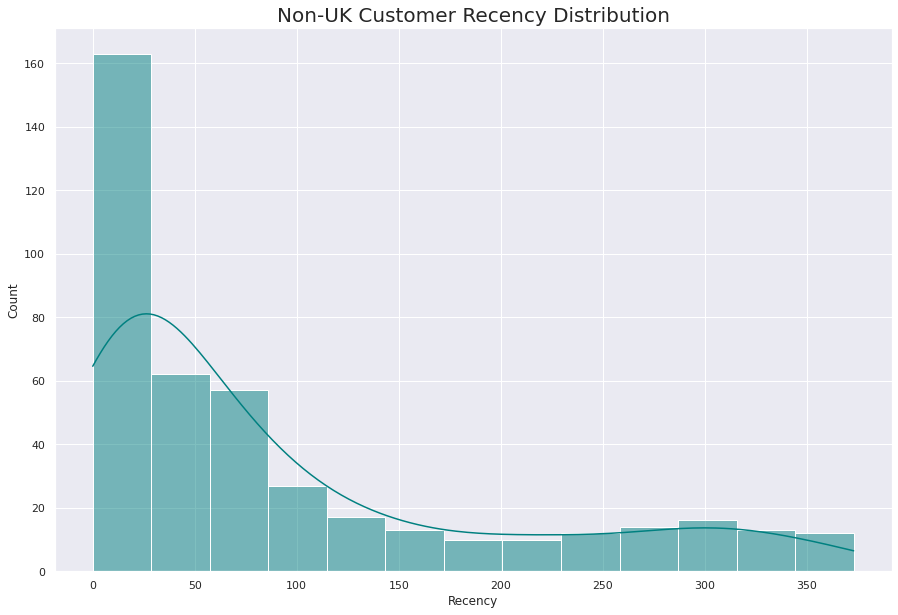

In [ ]:
# Non-UK Recency histogram plot
fig = plt.figure(figsize = (15,10))
sns.set(style = 'darkgrid')
_ = plt.title('Non-UK Customer Recency Distribution', fontsize = 20)
_ = sns.histplot(data_new['Recency'], color = 'teal', kde = True)
plt.show()

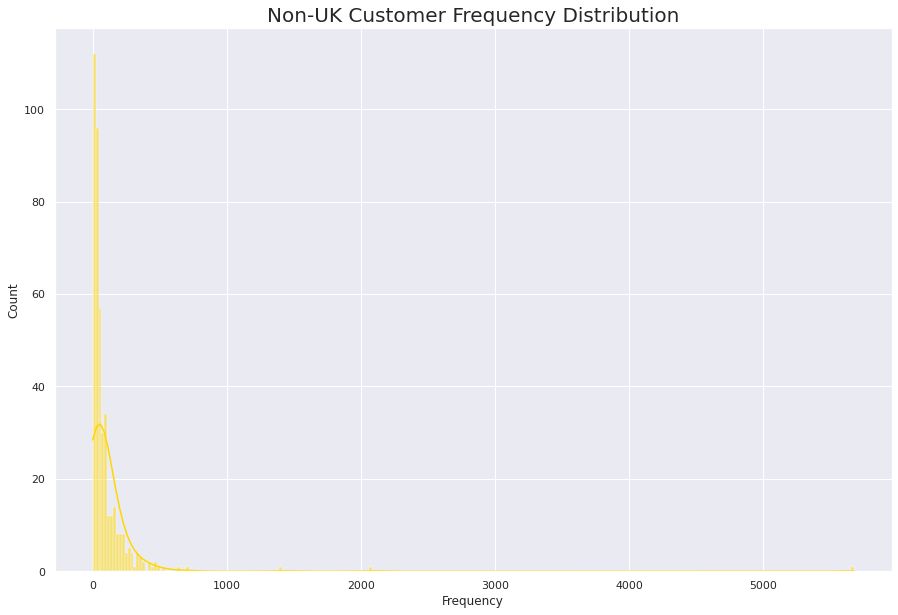

In [ ]:
# Non-UK Frequency histogram plot
fig = plt.figure(figsize = (15,10))
_ = plt.title('Non-UK Customer Frequency Distribution', fontsize = 20)
_ = sns.histplot(data_new['Frequency'], color = 'gold', kde = True)
plt.show()

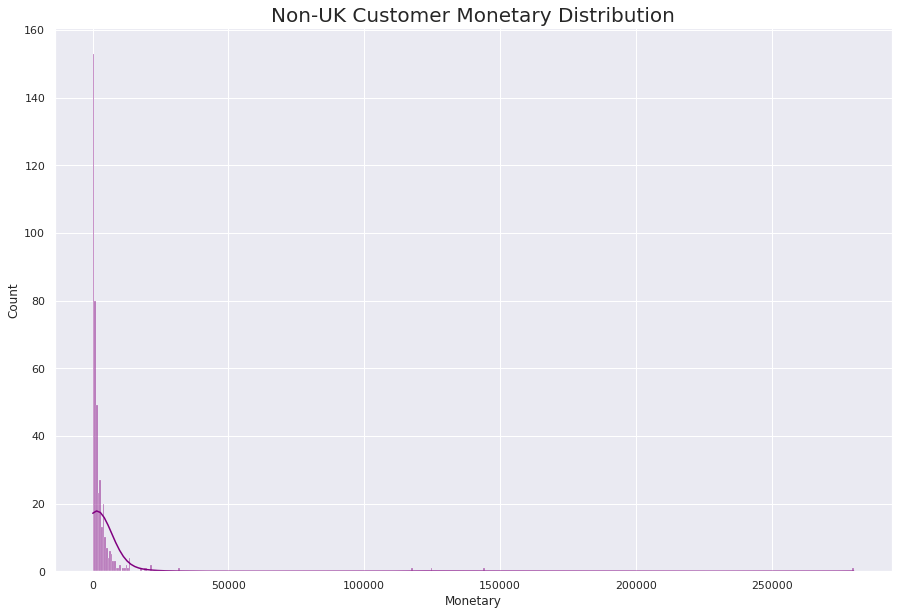

In [ ]:
# Non-UK Monetary histogram plot
fig = plt.figure(figsize = (15,10))
sns.set(style = 'darkgrid')
_ = plt.title('Non-UK Customer Monetary Distribution', fontsize = 20)
_ = sns.histplot(data_new['Monetary'], color = 'purple', kde = True)
plt.show()

# Feature Engineering

Segmenting non-UK customers may be more difficult because there are 36 different countries. So, we have to do one-hot encoding to each of them. Perhaps, we can try another idea to solve this problem.

 Let's try to make things easier by dividing the countries by their continents.

In [44]:
# create dictionary that contains name of existing country in dataset
country = ({'Country': ['Iceland', 'Finland', 'Italy', 'Norway', 'Bahrain', 'Spain',
                        'Portugal', 'Switzerland', 'Austria', 'Cyprus', 'Belgium',
                        'Unspecified', 'Denmark', 'Australia', 'France', 'Germany', 'RSA',
                        'Greece', 'Sweden', 'Israel', 'USA', 'Saudi Arabia', 'Poland',
                        'United Arab Emirates', 'Singapore', 'Japan', 'Netherlands',
                        'Lebanon', 'Brazil', 'Czech Republic', 'EIRE', 'Channel Islands',
                        'European Community', 'Lithuania', 'Canada', 'Malta']})

country = pd.DataFrame(country)

In [45]:
# do mapping
country['Continent'] = country['Country'].map({'Iceland': 'Europe', 'Finland': 'Europe', 
                                               'Italy': 'Europe', 'Norway': 'Europe', 'Bahrain': 'Asia', 
                                               'Spain': 'Europe', 'Portugal': 'Europe',
                                               'Switzerland': 'Europe', 'Austria': 'Europe', 
                                               'Cyprus': 'Europe', 'Belgium': 'Europe', 'Unspecified': 'Unspecified', 
                                               'Denmark': 'Europe', 'Australia': 'Australia', 'France': 'Europe', 
                                               'Germany': 'Europe', 'RSA': 'Africa', 'Greece': 'Europe', 
                                               'Sweden': 'Europe', 'Israel': 'Asia', 'USA': 'America',
                                               'Saudi Arabia': 'Asia', 'Poland': 'Europe',
                                               'United Arab Emirates': 'Asia', 'Singapore': 'Asia', 'Japan': 'Asia',
                                               'Netherlands': 'Europe', 'Lebanon': 'Asia', 'Brazil': 'America', 
                                               'Czech Republic': 'Europe', 'EIRE': 'Europe', 
                                               'Channel Islands': 'Europe', 'European Community': 'Europe', 
                                               'Lithuania': 'Europe', 'Canada': 'America', 'Malta': 'Europe'})
country

,Country,Continent
0,Iceland,Europe
1,Finland,Europe
2,Italy,Europe
3,Norway,Europe
4,Bahrain,Asia
5,Spain,Europe
6,Portugal,Europe
7,Switzerland,Europe
8,Austria,Europe
9,Cyprus,Europe


In [46]:
# merge
data_new = pd.merge(data_new, country, how = 'left', on=['Country'])
data_new.tail()

,Country,Recency,Frequency,Monetary,Continent
421,Canada,147,135,2940.04,America
422,Greece,280,22,387.31,Europe
423,Malta,22,67,1820.09,Europe
424,United Arab Emirates,298,30,889.24,Asia
425,Canada,106,5,51.56,America


## One-Hot Encoding

In [47]:
#one hot encoding
from sklearn.preprocessing import OneHotEncoder
column = ['Continent']
column_drop = ['Continent', 'Country']
ohe = OneHotEncoder()
ohe.fit(data_new[column])
data_ohe_res = pd.DataFrame(ohe.transform(data_new[column]).toarray(),
                          columns=ohe.get_feature_names_out())
data_new = pd.concat([data_new, data_ohe_res], axis=1)
data_new = data_new.drop(columns=column_drop)
data_new.head()

,Recency,Frequency,Monetary,Continent_Africa,Continent_America,Continent_Asia,Continent_Australia,Continent_Europe,Continent_Unspecified
0,1,182,4310.00,0.0,0.0,0.0,0.0,1.0,0.0
1,74,31,1797.24,0.0,0.0,0.0,0.0,1.0,0.0
2,18,73,1757.55,0.0,0.0,0.0,0.0,1.0,0.0
3,309,17,334.40,0.0,0.0,0.0,0.0,1.0,0.0
4,35,85,2506.04,0.0,0.0,0.0,0.0,1.0,0.0


## Scaling

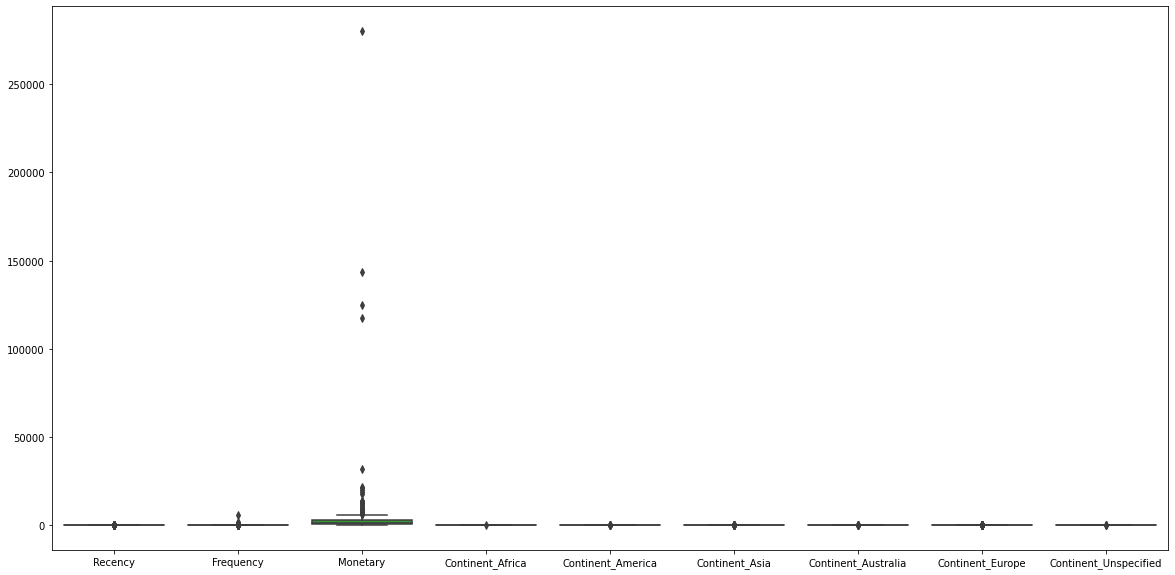

In [48]:
_ = plt.figure(figsize = (20,10))
_ = sns.boxplot(data = data_new)
plt.show()

In [49]:
# Scale the data

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_new)

data_scaled = pd.DataFrame(data_scaled, columns = data_new.columns, index = data_new.index)

data_scaled.head()

,Recency,Frequency,Monetary,Continent_Africa,Continent_America,Continent_Asia,Continent_Australia,Continent_Europe,Continent_Unspecified
0,-0.894515,0.249972,0.028090,-0.048507,-0.146911,-0.210042,-0.146911,0.326333,-0.097358
1,-0.190182,-0.236407,-0.115983,-0.048507,-0.146911,-0.210042,-0.146911,0.326333,-0.097358
2,-0.730492,-0.101123,-0.118259,-0.048507,-0.146911,-0.210042,-0.146911,0.326333,-0.097358
3,2.077191,-0.281502,-0.199857,-0.048507,-0.146911,-0.210042,-0.146911,0.326333,-0.097358
4,-0.566470,-0.062470,-0.075343,-0.048507,-0.146911,-0.210042,-0.146911,0.326333,-0.097358


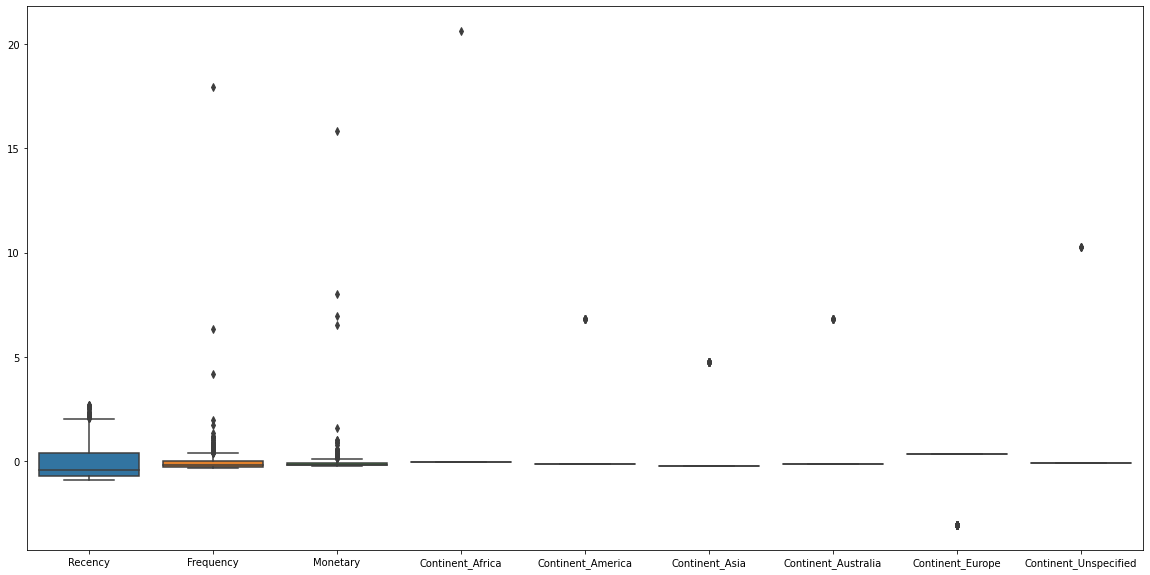

In [50]:
# Plot scaled data
_ = plt.figure(figsize = (20,10))
_ = sns.boxplot(data = data_scaled)
plt.show()

## Modeling

### Elbow Method

In [51]:
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
inertia = []

for k in possible_k:
    kmeans = KMeans(n_clusters = k, random_state = 123).fit(data_scaled)
    
    inertia.append(kmeans.inertia_)

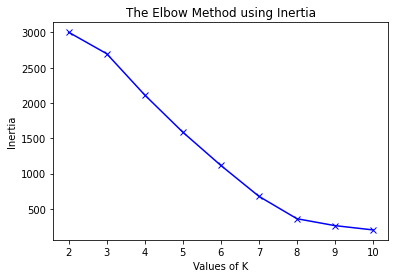

In [52]:
plt.plot(possible_k, inertia, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Plot shows that the best k = 2

### Silhouette Score

In [53]:
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters = k, random_state = 123).fit(data_scaled)
    
    silhouette.append(silhouette_score(X = data_scaled, labels = kmeans.labels_))

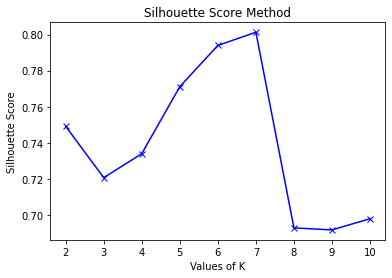

In [54]:
plt.plot(possible_k, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

By using silhouette score, the best k = 7

### Compare The Results

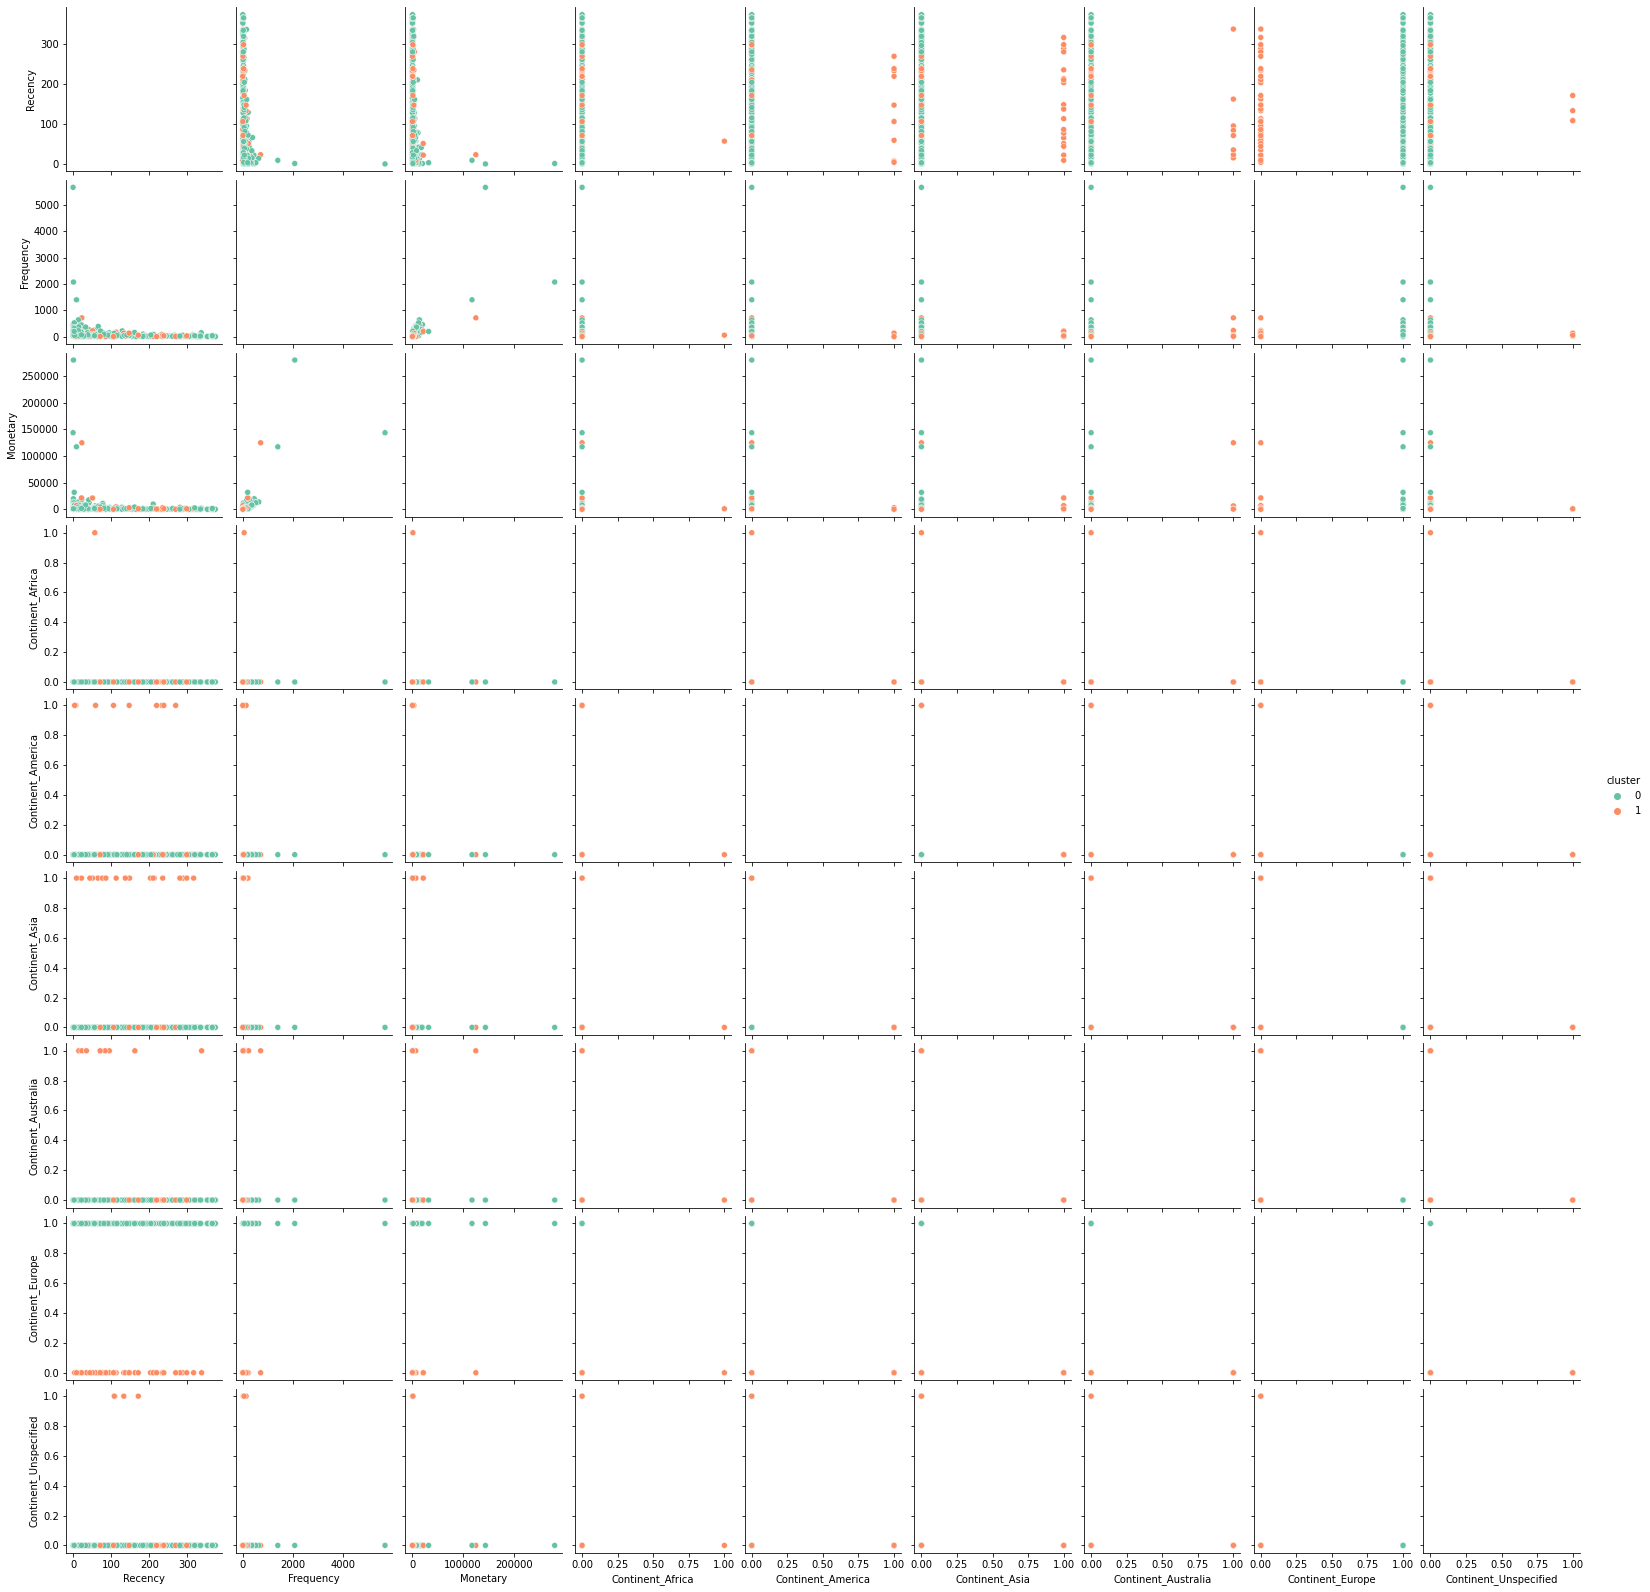

In [55]:
# 2 clusters

kmeans_2clust = KMeans(n_clusters = 2, random_state = 123).fit(data_scaled)

data_result_2clust = data_new.copy()
data_result_2clust['cluster'] = kmeans_2clust.labels_

sns.pairplot(data = data_result_2clust, hue = 'cluster', diag_kind = 'None', palette = 'Set2')

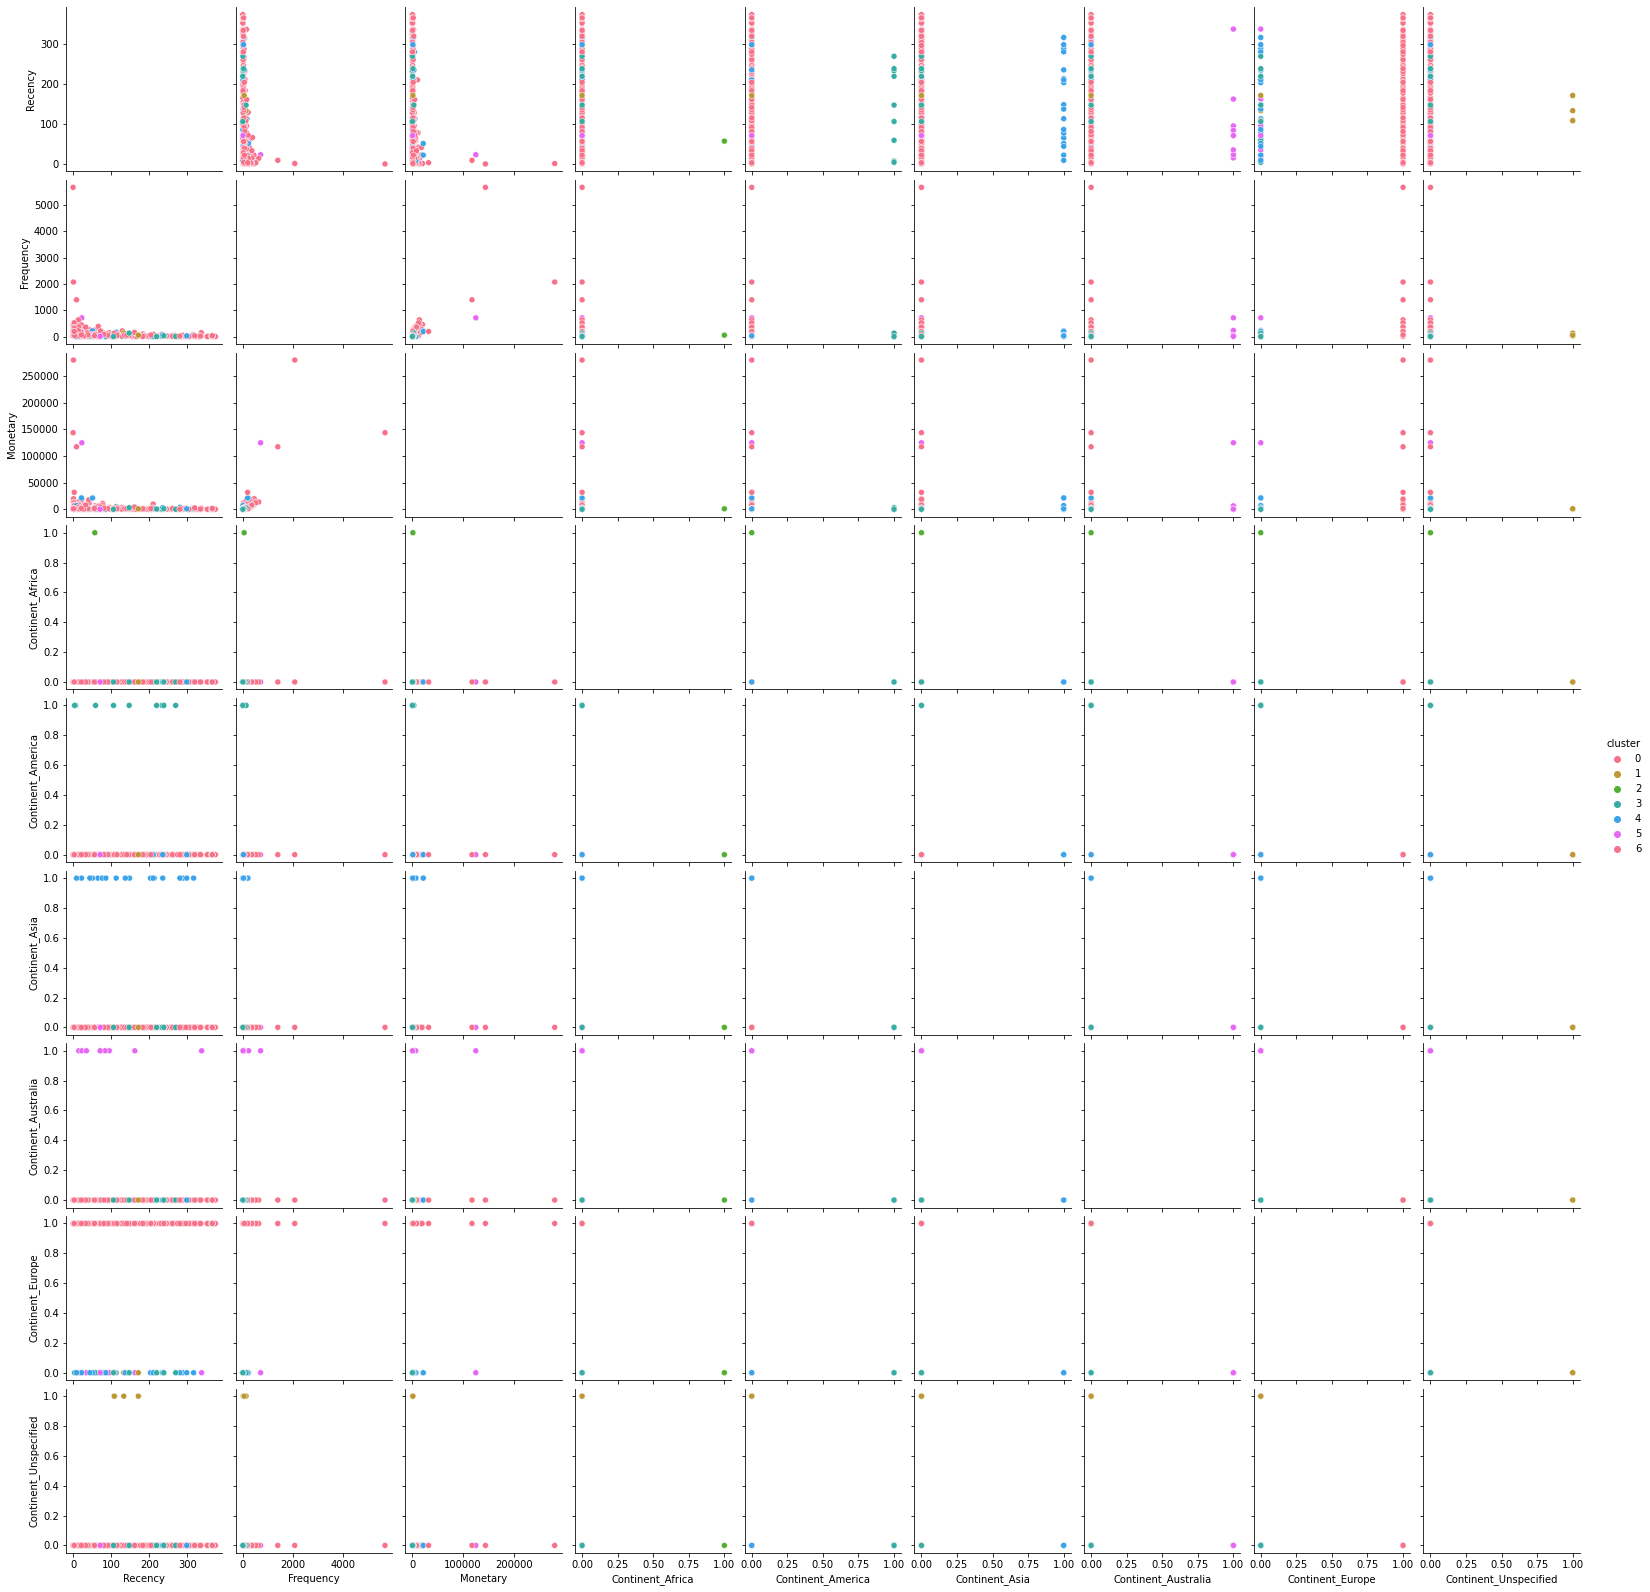

In [56]:
# 7 clusters

kmeans_7clust = KMeans(n_clusters = 7, random_state = 0).fit(data_scaled)

data_result_7clust = data_new.copy()
data_result_7clust['cluster'] = kmeans_7clust.labels_

sns.pairplot(data = data_result_7clust, hue = 'cluster', diag_kind = 'None', palette = 'husl')

In [57]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

drop_column = ['Continent_Africa', 'Continent_America', 'Continent_Asia',
               'Continent_Australia', 'Continent_Europe', 'Continent_Unspecified']

# Simple descriptive statistic
data_result_2clust \
    .drop(drop_column, axis = 1) \
    .groupby('cluster') \
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max']) \
    .transpose()

cluster                       0              1
Recency   mean        89.280519     135.317073
          std        103.669945      96.253166
          min          0.000000       4.000000
          q25         16.000000      59.000000
          median      43.000000     109.000000
          q75        116.000000     213.000000
          max        373.000000     337.000000
Frequency mean       108.116883      69.439024
          std        324.477167     119.828846
          min          2.000000       1.000000
          q25         23.000000      12.000000
          median      48.000000      32.000000
          q75        105.000000      63.000000
          max       5675.000000     714.000000
Monetary  mean      3649.808026    5419.000732
          std      17227.914247   19681.494863
          min         63.000000      51.560000
          q25        476.490000     401.900000
          median    1063.460000    1002.310000
          q75       2744.030000    2209.850000
          max     280206.020000  124914.530000

In [58]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

drop_column = ['Continent_Africa', 'Continent_America', 'Continent_Asia',
               'Continent_Australia', 'Continent_Europe', 'Continent_Unspecified']

# Simple descriptive statistic
data_result_7clust \
    .drop(drop_column, axis = 1) \
    .groupby('cluster') \
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max']) \
    .transpose()

cluster                       0            1        2            3  \
Recency   mean        89.744125   130.250000    57.00   142.444444   
          std        103.741232    29.522590      NaN   103.097176   
          min          0.000000   108.000000    57.00     4.000000   
          q25         16.500000   108.750000    57.00    59.000000   
          median      44.000000   121.000000    57.00   147.000000   
          q75        117.000000   142.500000    57.00   233.000000   
          max        373.000000   171.000000    57.00   269.000000   
Frequency mean        88.443864    61.000000    57.00    40.222222   
          std        119.100276    50.655701      NaN    46.964821   
          min          2.000000    23.000000    57.00     1.000000   
          q25         22.500000    29.000000    57.00    10.000000   
          median      47.000000    43.500000    57.00    22.000000   
          q75        105.000000    75.500000    57.00    45.000000   
          max       1400.000000   134.000000    57.00   135.000000   
Monetary  mean      2561.736319   666.767500  1002.31   932.263333   
          std       6746.284975   247.967842      NaN   933.201491   
          min         63.000000   530.180000  1002.31    51.560000   
          q25        472.375000   542.367500  1002.31   269.960000   
          median    1053.490000   549.215000  1002.31   534.240000   
          q75       2718.860000   673.615000  1002.31  1346.970000   
          max     117379.630000  1038.460000  1002.31  2940.040000   

cluster                      4              5              6  
Recency   mean      155.277778      99.222222       0.500000  
          std       102.325781      99.592643       0.707107  
          min         9.000000      15.000000       0.000000  
          q25        68.000000      35.000000       0.250000  
          median    142.500000      71.000000       0.500000  
          q75       229.500000      95.000000       0.750000  
          max       316.000000     337.000000       1.000000  
Frequency mean       51.666667     139.333333    3875.500000  
          std        69.316834     226.262569    2544.877305  
          min         4.000000      10.000000    2076.000000  
          q25         9.750000      30.000000    2975.750000  
          median     24.000000      50.000000    3875.500000  
          q75        44.500000     100.000000    4775.250000  
          max       222.000000     714.000000    5675.000000  
Monetary  mean     3900.435000   15545.716667  212015.540000  
          std      6625.171686   41057.334049   96435.901641  
          min        89.000000     373.650000  143825.060000  
          q25       287.080000     803.560000  177920.300000  
          median   1182.245000    1582.600000  212015.540000  
          q75      3611.647500    2780.660000  246110.780000  
          max     21429.390000  124914.530000  280206.020000